In [51]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [52]:
train = pd.read_csv('../input/Kannada-MNIST/train.csv')
test = pd.read_csv('../input/Kannada-MNIST/test.csv')

In [53]:
test = test.drop('id',axis=1)

In [54]:
test.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


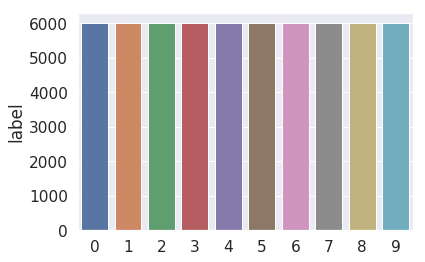

In [55]:
y = train.label.value_counts()
sns.barplot(y.index,y)

In [56]:
X_train = train.drop('label',axis=1)
Y_train = train.label

In [57]:
X_train = X_train / 255
test = test/255

In [58]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [59]:
Y_train = to_categorical(Y_train)

In [60]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,random_state=42,test_size=0.15)

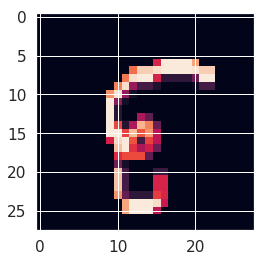

In [61]:
plt.imshow(X_train[0][:,:,0])

In [62]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [63]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation = "softmax"))

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)       

In [65]:
optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

In [66]:
model.compile(optimizer=optimizer,loss=['categorical_crossentropy'],metrics=['accuracy'])

In [67]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr = 0.00001)

In [68]:
epochs = 5
batch_size = 64

In [69]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Train for 796 steps, validate on 9000 samples
Epoch 1/5
796/796 - 18s - loss: 0.2612 - accuracy: 0.9172 - val_loss: 0.0420 - val_accuracy: 0.9880
Epoch 2/5
796/796 - 17s - loss: 0.0630 - accuracy: 0.9811 - val_loss: 0.0310 - val_accuracy: 0.9918
Epoch 3/5
796/796 - 17s - loss: 0.0522 - accuracy: 0.9851 - val_loss: 0.0319 - val_accuracy: 0.9907
Epoch 4/5
796/796 - 17s - loss: 0.0427 - accuracy: 0.9873 - val_loss: 0.0280 - val_accuracy: 0.9924
Epoch 5/5
796/796 - 17s - loss: 0.0387 - accuracy: 0.9883 - val_loss: 0.0169 - val_accuracy: 0.9953


Text(0, 0.5, 'accuracy')

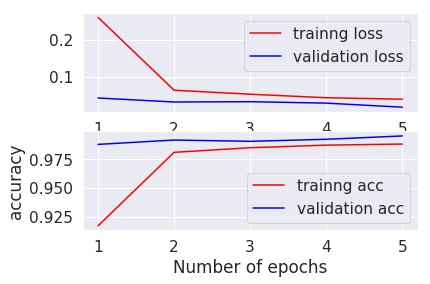

In [70]:
fig,ax=plt.subplots(2,1)
fig.set
x=range(1,1+epochs)
ax[0].plot(x,history.history['loss'],color='red')
ax[0].plot(x,history.history['val_loss'],color='blue')

ax[1].plot(x,history.history['accuracy'],color='red')
ax[1].plot(x,history.history['val_accuracy'],color='blue')

ax[0].legend(['trainng loss','validation loss'])
ax[1].legend(['trainng acc','validation acc'])
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')

In [71]:
y_pre_test = model.predict(X_test)
y_pre_test = np.argmax(y_pre_test,axis=1)
y_test = np.argmax(y_test,axis=1)

In [72]:
conf = confusion_matrix(y_test,y_pre_test)
conf = pd.DataFrame(conf,index=range(0,10),columns=range(0,10))

In [73]:
conf

,0,1,2,3,4,5,6,7,8,9
0,847,10,0,1,0,0,0,0,0,0
1,0,912,0,0,0,0,0,0,0,1
2,1,0,907,0,0,0,0,0,0,0
3,0,1,0,884,0,1,0,4,0,0
4,0,0,0,1,923,0,0,0,0,2
5,0,1,0,0,0,873,0,0,0,0
6,0,0,0,1,0,0,855,6,0,0
7,0,0,0,1,0,0,1,931,0,0
8,1,0,0,0,0,0,0,0,917,0
9,0,0,0,0,0,0,8,0,1,909


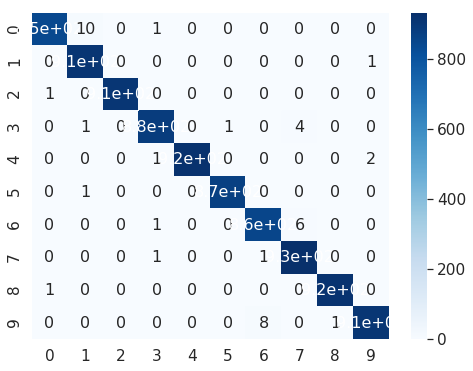

In [74]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf,annot=True,annot_kws={"size":16},cmap=plt.cm.Blues)

In [75]:
x = (y_pre_test-y_test!=0).tolist()
x = [i for i,l in enumerate(x) if l!=False]

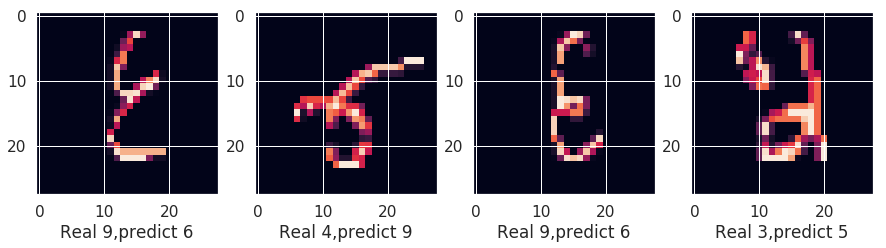

In [76]:
fig,ax=plt.subplots(1,4,sharey=False,figsize=(15,15))

for i in range(4):
    ax[i].imshow(X_test[x[i]][:,:,0])
    ax[i].set_xlabel('Real {},predict {}'.format(y_test[x[i]],y_pre_test[x[i]]))

In [77]:
test = pd.read_csv('../input/Kannada-MNIST/test.csv')

In [78]:
test_id=test.id

test=test.drop('id',axis=1)
test=test/255
test=test.values.reshape(-1,28,28,1)

In [79]:
test.shape

(5000, 28, 28, 1)

In [80]:
y_pre = model.predict(test)
y_pre = np.argmax(y_pre,axis=1)

In [81]:
sample_sub = pd.DataFrame()

In [82]:
sample_sub['label']=y_pre
sample_sub.to_csv('../output/samplesubmission.csv',index=False)